In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset

from torch import optim
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import transforms

In [2]:
df_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
df_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [3]:
n_pixel = len(df_train.columns) - 1
n_class = df_train['label'].nunique()
(n_pixel, n_class)

(784, 10)

In [4]:
class MNISTDataset(Dataset):
    def __init__(self, df, transform=None):
        self.transform = transform
        
        if len(df.columns) == n_pixel:
            self.X = df.values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.y = None
        else:
            self.X = df.iloc[:, 1:].values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx] 
        else:
            return self.transform(self.X[idx])

In [5]:
tfs = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.RandomRotation(20),
            transforms.ToTensor(), 
            transforms.Normalize(mean=(0.5,), std=(0.5,))
        ]
    ) 

In [6]:
train_data = MNISTDataset(
    df=df_train,
    transform=tfs
)

test_data = MNISTDataset(
    df=df_test,
    transform=tfs
)

In [7]:
from torch.utils.data import Dataset, SubsetRandomSampler

batch_size = 64

data_size = len(train_data)
validation_fraction = 0.2

validation_split = int(np.floor(validation_fraction * data_size))
indices = list(range(data_size))

np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:validation_split], indices[validation_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=train_sampler
)

val_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=val_sampler
)

In [8]:
device = torch.device("cuda:0") 

## Variation #1 of training model

In [83]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=(1, 1), bias=False),
    nn.BatchNorm2d(num_features=32, momentum=1e-3),
    nn.GELU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(1, 1), bias=False),
    nn.BatchNorm2d(num_features=64, momentum=1e-3),
    nn.GELU(),
    nn.MaxPool2d(kernel_size=(2, 2)),
    
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=(1, 1), bias=False),
    nn.BatchNorm2d(num_features=128, momentum=1e-3),
    nn.GELU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=(1, 1), bias=False),
    nn.BatchNorm2d(num_features=256, momentum=1e-3),
    nn.GELU(),
    nn.MaxPool2d(kernel_size=(2, 2)),
    
    nn.Flatten(),
    nn.Linear(7*7*256, 256),
    nn.BatchNorm1d(256, momentum=1e-3),
    nn.GELU(),
    nn.Linear(256, 10)
)

model.type(torch.cuda.FloatTensor)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=4, verbose=True)
criterion = nn.CrossEntropyLoss()

In [84]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=50):
    train_losses = []
    val_losses = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        loss_accum = 0.0
        correct_samples = 0
        total_samples = 0
        
        for idx, (X, y) in enumerate(train_loader):
            X_gpu = X.to(device)
            y_gpu = y.to(device)
            
            preds = model(X_gpu)
            loss = criterion(preds, y_gpu)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, indices = torch.max(preds, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss
            
        train_avg_loss = loss_accum / idx
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy, val_avg_loss = validate_model(model, criterion, val_loader)
        
        train_losses.append(train_avg_loss)
        val_losses.append(val_avg_loss)
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        scheduler.step(train_avg_loss)
        
        print(
            "Train loss: %f, Val loss: %f, Train accuracy: %f, Val accuracy: %f" % (train_avg_loss, val_avg_loss, train_accuracy, val_accuracy)
        )
        
    return train_losses, val_losses, train_history, val_history
        
        
@torch.no_grad()
def validate_model(model, criterion, val_loader):
    model.eval()
    
    loss_accum = 0.0
    correct_samples = 0
    total_samples = 0
    
    for idx, (X, y) in enumerate(val_loader):
        X_gpu = X.to(device)
        y_gpu = y.to(device)
        
        preds = model(X_gpu)
        loss = criterion(preds, y_gpu)
        
        _, indices = torch.max(preds, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
        
        loss_accum += loss
        
    val_accuracy = float(correct_samples) / total_samples
    val_avg_loss = loss_accum / idx
    
    return val_accuracy, val_avg_loss

In [89]:
train_losses, val_losses, train_history, val_history = train_model(
    model, train_loader, val_loader, optimizer, scheduler, criterion, num_epochs=100
)

Train loss: 0.004829, Val loss: 0.018940, Train accuracy: 0.998750, Val accuracy: 0.994405
Train loss: 0.004775, Val loss: 0.018619, Train accuracy: 0.998988, Val accuracy: 0.994286
Train loss: 0.004378, Val loss: 0.016610, Train accuracy: 0.999167, Val accuracy: 0.994643
Train loss: 0.004175, Val loss: 0.018440, Train accuracy: 0.999226, Val accuracy: 0.994643
Train loss: 0.004396, Val loss: 0.018844, Train accuracy: 0.999167, Val accuracy: 0.994048
Train loss: 0.003833, Val loss: 0.016929, Train accuracy: 0.999137, Val accuracy: 0.994881
Train loss: 0.003990, Val loss: 0.018429, Train accuracy: 0.999256, Val accuracy: 0.994048
Train loss: 0.004443, Val loss: 0.016157, Train accuracy: 0.999107, Val accuracy: 0.994762
Train loss: 0.003917, Val loss: 0.014952, Train accuracy: 0.998988, Val accuracy: 0.994405
Train loss: 0.003678, Val loss: 0.018168, Train accuracy: 0.999375, Val accuracy: 0.994524
Train loss: 0.003831, Val loss: 0.018155, Train accuracy: 0.999137, Val accuracy: 0.994167

KeyboardInterrupt: 

In [90]:
train_losses = [float(x) for x in train_losses]
val_losses = [float(x) for x in val_losses]
train_history = [float(x) for x in train_history]
val_history = [float(x) for x in val_history]

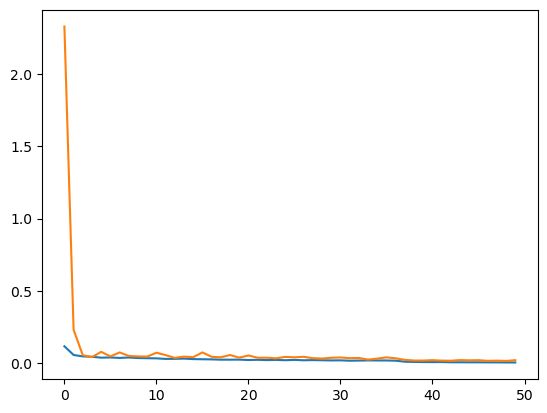

In [91]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

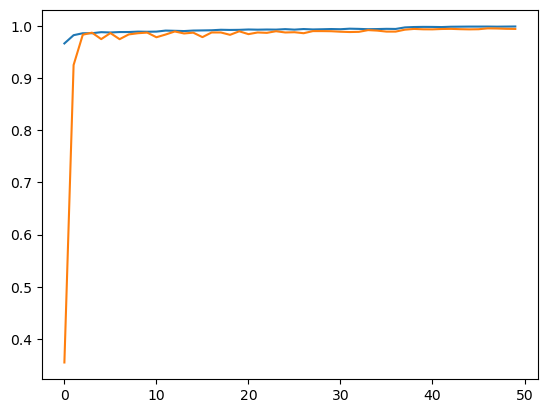

In [92]:
plt.plot(train_history)
plt.plot(val_history)
plt.show()

In [95]:
test_dataset = MNISTDataset(
    df_test,
    transform=tfs
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


model.eval()
    
predicted_indices = []
    
for idx, X in enumerate(test_loader):
    X_gpu = X.to(device)

    preds = model(X_gpu)

    _, indices = torch.max(preds, 1)
    predicted_indices.extend([int(i) for i in indices])

In [96]:
submit = pd.DataFrame()
submit['ImageId'] = range(1, len(predicted_indices) + 1)
submit['Label'] = predicted_indices

submit.to_csv("submission_100epochCNN_attempt4.csv", index=False)